#Graph 1

In [ ]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import jax
from jax import grad, vmap
import jax.numpy as jnp
import torch
import tqdm
import scipy
from scipy import integrate

In [ ]:
jax.config.update("jax_enable_x64", True)

In [ ]:
#Exponential kernel for two inputs i.e. ID
def kernel(s,t,params):
  #K = jnp.exp(-(s-t)**2/(2*params[0]**2))
  K = (1+jnp.sqrt(5)*jnp.abs(s-t)/params[0]+5/3*jnp.abs(s-t)**2/params[0]**2)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])
  return K

In [ ]:
def kernel_u(s,t,params):
  #K = -(s-t)*kernel(s,t,params)/params[0]**2
  K = -5*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(params[0]+jnp.sqrt(5)*jnp.abs(s-t))/(3*params[0]**3)
  return K

def kernel_z(s,t,params):
  #K = (s-t)*kernel(s,t,params)/params[0]**2
  K = 5*(s-t)*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(params[0]+jnp.sqrt(5)*jnp.abs(s-t))/(3*params[0]**3)
  return K

def kernel_uz(s,t,params):
  #K = (params[0]**2-(s-t)**2)*kernel(s,t,params)/params[0]**4
  K = 5*jnp.exp(-jnp.sqrt(5)*jnp.abs(s-t)/params[0])*(jnp.sqrt(5)*params[0]*jnp.abs(s-t)+params[0]**2-5*(s-t)**2)/(3*params[0]**4)
  return K

In [ ]:
#Start and end times for space (x) and time (t)
xbegin=0
xfinal=1
Tstart=0
Tend=1
#Space step
h=1/100
#Time step
c=1/1000000
x = np.arange(xbegin, xfinal+h, h)
t = np.arange(Tstart, Tstart+2*c, c)

m=len(x)-1
p=len(t)-1

In [ ]:
def linearize(u):
  return jnp.exp((u**3-1)/3)

def error(u,u_true):
  return jnp.linalg.norm(u-u_true)/jnp.linalg.norm(u_true)

def rkhs_norm(K,Y):
  return Y[:,0].dot(jnp.linalg.inv(K)@Y)

In [ ]:
nonlin_test=np.zeros((m+1,p+2))
nonlin_train1=np.zeros((m+1,p+2))


nonlin_train1[:,0] = jnp.cbrt(3*jnp.log(jnp.exp(x)*jnp.cosh(-x))+1)
nonlin_dx_train1=np.zeros((m+1,p+1))
nonlin_dx2_train1=np.zeros((m+1,p+1))
nonlin_dx3_train1=np.zeros((m+1,p+1))

nonlin_test[:,0] = nonlin_train1[:,0]
nonlin_dx_test=np.zeros((m+1,p+1))
nonlin_dx2_test=np.zeros((m+1,p+1))
nonlin_dx3_test=np.zeros((m+1,p+1))

#Solve nonlins numerical via Euler
for n in range(p+1):
    spl0 = scipy.interpolate.splrep(x,nonlin_test[:,n],k=3)
    nonlin_dx_test[:,n] = scipy.interpolate.splev(x,spl0,der=1)
    nonlin_dx2_test[:,n] = scipy.interpolate.splev(x,spl0,der=2)
    nonlin_dx3_test[:,n] = scipy.interpolate.splev(x,spl0,der=3)
    nonlin_test[:,n+1] = (nonlin_dx_test[:,n] - 1/nonlin_test[:,n]**2+nonlin_test[:,n]/c)*c

    spl1 = scipy.interpolate.splrep(x,nonlin_train1[:,n],k=3)
    nonlin_dx_train1[:,n] = scipy.interpolate.splev(x,spl1,der=1)
    nonlin_dx2_train1[:,n] = scipy.interpolate.splev(x,spl1,der=2)
    nonlin_dx3_train1[:,n] = scipy.interpolate.splev(x,spl1,der=3)
    nonlin_train1[:,n+1] =  (nonlin_dx_train1[:,n] - 1/nonlin_train1[:,n]**2+nonlin_train1[:,n]/c)*c

In [ ]:
linearize(jnp.cbrt(3*jnp.log(jnp.exp(-10)*jnp.cosh(10))-1))

Array(0.25670856, dtype=float64, weak_type=True)

In [ ]:
nonlin_train = nonlin_train1
nonlin_dx_train = nonlin_dx_train1
nonlin_dx2_train = nonlin_dx2_train1
nonlin_dx3_train = nonlin_dx3_train1

In [ ]:
#Kernel matrix as function of one vector
def K_Matrix(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  val = vmap(lambda s, t: kernel(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())

  K_matrix=np.reshape(val,(size,size2))
  if reg==True and size==size2:
    K_matrix+=+nugget*jnp.eye(size)
  return K_matrix

In [ ]:
#Second derivative with respect to x
def K_du(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_du = vmap(lambda s, t: kernel_u(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_du = np.reshape(K_du,(size,size2))

  if reg==True and size==size2:
    K_du+=+nugget*jnp.eye(size)
  return K_du

In [ ]:
#Second derivative with respect to y
def K_dz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_dz = vmap(lambda s, t: kernel_z(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_dz = np.reshape(K_dz,(size,size2))

  if reg==True and size==size2:
    K_dz+=+nugget*jnp.eye(size)
  return K_dz

In [ ]:
#Second derivative with respect to x
def K_duz(X,Y,params,reg=False,nugget=10**-5):
  size=len(X[:,0])
  size2=len(Y[:,0])
  X0=jnp.transpose(jnp.tile(X[:,0],(size2,1)))
  Y0=jnp.transpose(jnp.tile(Y[:,0],(size,1)))

  K_duz = vmap(lambda s, t: kernel_uz(s,t,params))(X0.flatten(),np.transpose(Y0).flatten())
  K_duz = np.reshape(K_duz,(size,size2))


  if reg==True and size==size2:
    K_duz+=+nugget*jnp.eye(size)
  return K_duz

In [ ]:
size = len(nonlin_train[:,0])

u0 = nonlin_train[:,0].reshape((size,1))


Y = np.eye(1,size+1).reshape((size+1,1))

In [ ]:
def matrix_assembly(X,params):

  #Constructs K(\phi,\phi)
  size = len(X[:,0])
  K = jnp.zeros((size+1,size+1))
  K_u = K_du(X,X,params)
  K_z = K_dz(X,X,params)
  K_uz = K_duz(X,X,params)
  K_00 = K_Matrix(X,X,params)


  K = K.at[1:size+1,1:size+1].set(jnp.outer(1/X[:,0]**2,1/X[:,0]**2)*K_uz - 1/X**2*K_u - 1/X[:,0]**2*K_z+K_00)
  K = K.at[0,0].set(kernel(1,1,params))


  K = K.at[1:size+1,0].set(1/X[:,0]**2*jnp.diag(K_du(X,jnp.ones((size,1)),params))-kernel(X,1,params)[:,0])
  K = K.at[0,1:size+1].set(K[1:size+1,0])


  return K

In [ ]:
#Construct K(\phi,\phi)
#K = np.zeros((size+1,size+1))

#K[1:size+1,1:size+1] = jnp.outer(1/nonlin_train[:,0]**2,1/nonlin_train[:,0]**2)*K_uz - 1/u0**2*K_u - 1/nonlin_train[:,0]**2*K_z+K_00

#K[0,0] = kernel(1,1,params)
#$K[1:size+1,0] = 1/nonlin_train[:,0]**2*np.diag(K_du(u0,np.ones((size,1)),params))-kernel(u0,1,params)[:,0]
#K[0,1:size+1] = K[1:size+1,0]

In [ ]:
#Computes vector K(x,X)
#def K_vector(X_test,X_train,params=params):
  #size=len(X_test[:,0])
  #size2 = len(X_train[:,0])

  #K_vector = np.zeros((size,size2+1))

  #Y2 = jnp.array(X_train[:,0]).reshape((size2,1))

  #test = X_test[:,0].reshape((size,1))

  #K_vector[:,1:size+1] =  1/jnp.array(X_train[:,0])**2*K_dz(X_test,Y2,params)-K_Matrix(X_test,Y2,params)

  #K_vector[:,0] = kernel(test,1,params)[:,0]

  #return K_vector

In [ ]:
#Computes vector K(u,\phi)
def K_vector(X_test,X_train,params):
  size=len(X_test[:,0])
  size2 = len(X_train[:,0])

  Y2 = jnp.array(X_train[:,0]).reshape((size2,1))

  K_vector = jnp.zeros((size,size2+1))

  X_test = X_test[:,0].reshape((size,1))
  X_train = X_train[:,0].reshape((size2,1))


  K_vector = K_vector.at[:,1:size2+1].set(1/jnp.array(X_train[:,0])**2*K_dz(X_test,Y2,params)-K_Matrix(X_test,Y2,params))

  #K(u,\phi_1)
  K_vector = K_vector.at[:,0].set(jnp.diag(K_Matrix(X_test,jnp.ones((size,1)),params,nugget=False)))


  return K_vector

In [ ]:
train_size = len(nonlin_train[:,0])
train = nonlin_train[:,0].reshape((train_size,1))

In [ ]:
#Create K(\phi,\phi)
params = jnp.array([0.1])
test = nonlin_test[:,0]
test = test.reshape((len(test),1))
K = matrix_assembly(train,params)


In [ ]:
#Kernel regression for one dimension K(x,X)K(X,X)^-1 Y
def kernel_regression(X_test,X_train, Y_train,K_matrix=K,params=params,nugget=1*10**-10):
    t_matrix = K_vector(X_test,X_train,params=params)
    prediction = jnp.matmul(t_matrix,jnp.linalg.inv(K_matrix+nugget*np.eye(len(K_matrix[:,0])))@Y_train)
    return prediction

In [ ]:
results = kernel_regression(nonlin_test[:,0].reshape((m+1,1)),nonlin_train,Y_train=Y)

Text(0.5, 1.0, 'Recovery of linear PDE (against x)')

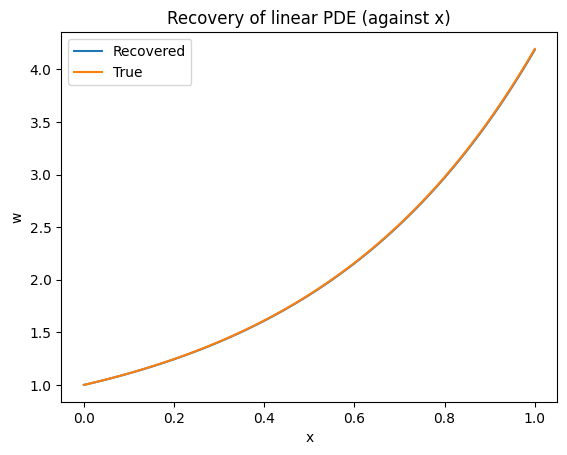

In [ ]:
plt.plot(x,results)
plt.plot(x,linearize(nonlin_test[:,0]))
plt.xlabel('x')
plt.ylabel('w')
plt.legend(['Recovered','True'])
plt.title('Recovery of linear PDE (against x)')

In [ ]:
#test error
error(results[:,0],linearize(nonlin_test[:,0]))

Array(0.00210235, dtype=float64)

Text(0.5, 1.0, 'Recovered transformation')

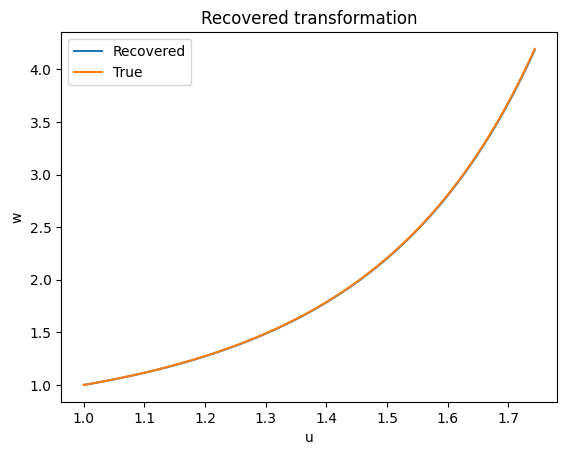

In [ ]:
plt.plot(nonlin_test[:,0],results[:,0])
plt.plot(nonlin_test[:,0],linearize(nonlin_test[:,0]))
plt.xlabel('u')
plt.ylabel('w')
plt.legend(['Recovered','True'])
plt.title('Recovered transformation')